# Basics of brain network modeling and running an example simulation

## A primer on brain network modeling

A neural mass model (NMM) mathematically represents the behavior and dynamics of a local population of neurons, abstracted into interacting neuronal ensembles that can model the activity of a brain area (node). A brain network model (BNM) is built by connecting brain areas, each modeled as an NMM, via a connectome. This connectome is often represented by a structural connectivity (SC) matrix, which quantifies the strength of white matter connections between different regions. Through the connectome, nodes (NMMs) influence each other’s activity while maintaining their local dynamics. As a result, a BNM can simulate the dynamics of the entire brain or a part of it (e.g. the cerebral cortex).

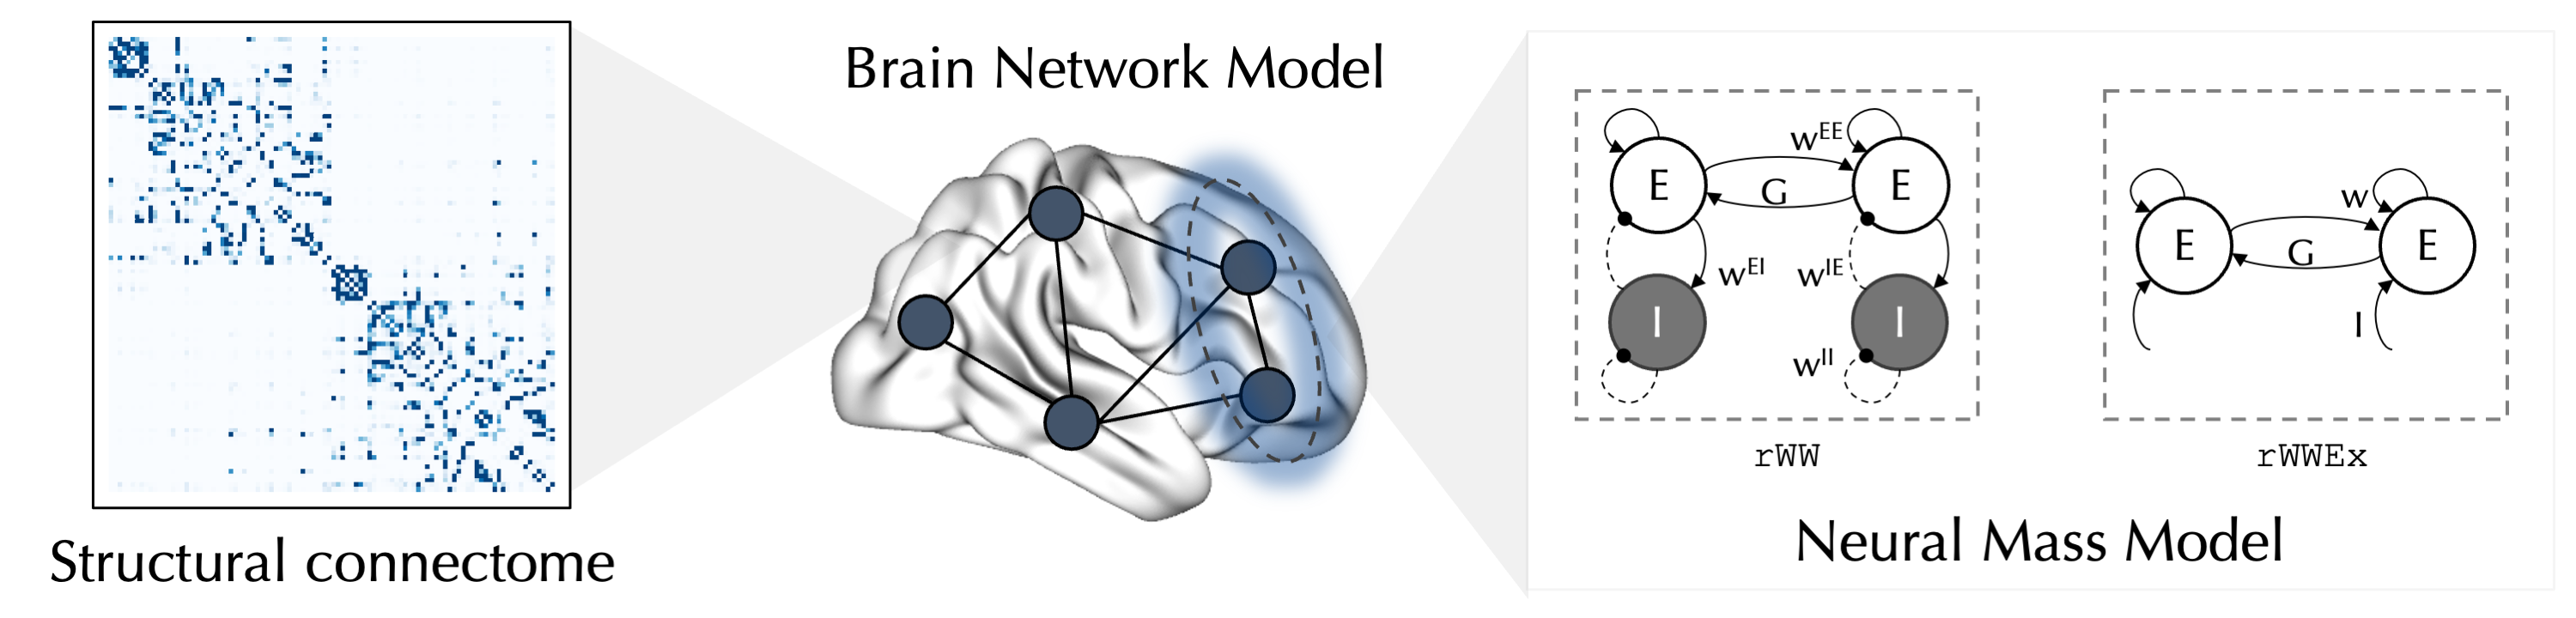

These simulations can be used in theoretical studies to investigate, *in silico*, how different model characteristics and parameters influences the resulting dynamics. Another main aim of studies using BNMs is to generate simulations that are most fitting to the empirical data obtained from a subject or a group of subjects, thereby creating a BNM that reflects that subject/group. This will require that an additional forward model that transforms the simulated NMMs activity to the level of empirical observations. A common type of the empirical functional data that is used for this purpose (and is supported by the toolbox), is the blood-oxygen-level-dependent (BOLD) signal measured during resting-state functional magnetic resonance imaging. The Balloon-Windkessel model of hemodynamics can be used to simulate BOLD signal in each node based on the simulated activity of its NMM. The simulated BOLD signal can then be compared with the empirical BOLD signal to assess its goodness-of-fit (GOF). Two measures derived from BOLD signal are commonly used to assess GOF of simulated to empirical BOLD signal:

- Functional connectivity (FC) matrix, which is calculated as the correlation of (simulated/empirical) BOLD signal time series between nodes. We aim for a simulated FC that is similar to the empirical FC, which is often quantified by calculating the Pearson correlation of the two matices.
- Functional connectivity dynamics (FCD) matrix, which is constructed by calculating the correlation of dynamic FC patterns between sliding windows of BOLD signal. The distribution of values in the FCD matrices is compared between the simulated and empirical FCDs using Kolmogorov-Smirnov distance, as a measure of similarity in network dynamics.

These measures are further discussed in the subsequent sections of this tutorial.

## Reduced Wong-Wang BNM

When constructing a BNM, several decisions need to be made, including: i. the choice of NMM that describe the activity of each node, ii. the definition of nodes (the choice of atlas and the areas to include), and iii. the choice of connectome (i.e., from a template, group-averaged data, or subject-specific SCs).

In this tutorial we will show an example of a BNM constructed from the reduced Wong-Wang (rWW) NMM [[Deco et al. 2014](https://doi.org/10.1523/JNEUROSCI.5068-13.2014)], using Scheafer parcellation with 100 cortical nodes and by using the example group-averaged SC included in the toolbox. We will then show how the resulting example simulation compares to the pooled real (empirical) resting-state fMRI BOLD data of the group.

In the rWW model, as shown in the figure above, each node (NMM) consists of an excitatory (E) and an inhibitory (I) neuronal population which are connected through a set of weights: $w^{EE}$ (recurrent excitatory connection weight), $w^{EI}$ (excitatory to inhibitory connection weight), $w^{IE}$ (inhibitory to excitatory connection weight) and $w^{II}$ (recurrent inihibitory connection weight). The nodes are connected to each other through their E neuronal ensembles and based on the strength of SC between them ($C_{ij}$) scaled by a parameter $G$ (global coupling). In addition, to model influence of stochastic fluctuations on the node dynamics, Gaussian noise is injected into the model. Here is the system of differntial equations describing the rWW BNM:

$I_i^E\left(t\right)=W^EI_b+w_i^{EE}S_i^E\left(t\right)+GJ_{NMDA}\sum_{j}^{N}{C_{ij}S_j^E\left(t\right)}-w_i^{IE}S_i^I(t)\ $

$I_i^I\left(t\right)=W^II_b+w_i^{EI}S_i^E\left(t\right)-w^{II}S_i^I\left(t\right)$

$r_i^E\left(t\right)=H^E(I_i^E)\ =\frac{a^EI_i^E(t)-b^E}{1\ -\ e^{-d^E(a^EI_i^E(t)-b^E)}}$

$r_i^I\left(t\right)=H^I(I_i^I)\ =\frac{a^II_i^I(t)-b^I}{1\ -\ e^{-d^I(a^II_i^I(t)-b^I)}}$

$\frac{dS_i^E(t)}{dt}=-\frac{S_i^E\left(t\right)}{\tau_E}+\left(1\ -\ S_i^E\left(t\right)\right)\gamma r_i^E\left(t\right)+\sigma\nu_i(t)$

$\frac{dS_i^I(t)}{dt}=-\frac{S_i^I\left(t\right)}{\tau_I}+r_i^I\left(t\right)+\sigma\nu_i(t)$

In this model (and in our implementation of it), while most of the model parameters are fixed, four are variable and can be tuned to alter the simulation: $G$, which is a global parameter (can vary across simulations), and $w_i^{EE}$, $w_i^{EI}$ and $w_i^{IE}$ which are regional parameters (can vary across simulations and nodes). While $G$, $w_i^{EE}$ and $w_i^{EI}$ are "free parameters" determined by the user (or optimization algorithm, more on this in the next tutorials), $w_i^{IE}$ is (by default) determined via "Feedback Inhibition Control" (FIC) algorithm which aims to maintain the firing rate of E neurons within a biologically plausible range of 3 Hz [[Deco et al. 2014](https://doi.org/10.1523/JNEUROSCI.5068-13.2014), [Demirtas et al. 2019](https://doi.org/10.1016/j.neuron.2019.01.017)]. Note that FIC is specific to the rWW model.

Given a set of candidate free parameters and the given connectome, the toolbox will numerically integrate the system of differential equations using Euler-Maruyama method, and generate simulated time series of all model states, including input current ($I$), firing rate ($r$) and synaptic gating ($S$) of E and I neuronal ensembles in each node. The simulated synaptic gating of the E population ($S_i^E$) is then fed to the Balloon-Windkessel model of hemodynamics to simulate BOLD signal, which is then sampled at intervals similar to the repetition time (TR) of the empirical BOLD data.

## Run an example simulation of rWW BNM

We should first define the structural connectome (SC) that determines the presence and strength of connections between pairs of nodes. In the toolbox we have included an example SC matrix. This example SC is based on the diffusion weighted imaging (DWI) data of 706 healthy individuals from the HCP-YA dataset (these are our randomly selected train dataset subjects in the so-called `'group-train706'`). Let's load and visualize this matrix:

<Axes: >

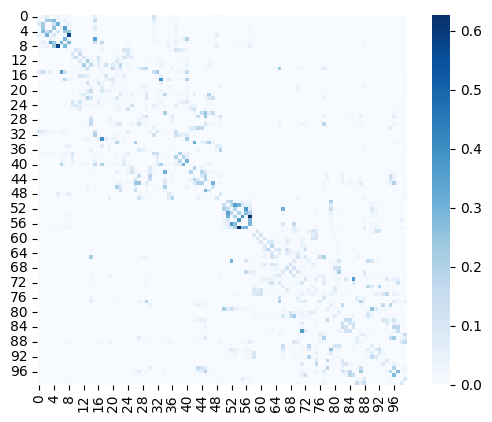

In [1]:
from cubnm import datasets
import seaborn as sns
import matplotlib.pyplot as plt

sc = datasets.load_sc('strength', 'schaefer-100', 'group-train706')

# plot it
sns.heatmap(sc, cmap='Blues', square=True)

<div class="alert alert-info">
<p>
    Note: To construct a subject-specific BNM diffusion weighted imaging (DWI) data can be used to create subject-specific SCs. DWI data can be processed into a SC matrix using tools such as [MRtrix](https://mrtrix.readthedocs.io/en/latest/) or its wrapper pipelines such as [Micapipe](https://micapipe.readthedocs.io/en/latest/). Example subject-specific SCs are included in the toolbox and can be loaded using `cubnm.datasets.load_sc`.
</p>
</div>

Next, we construct a rWW BNM using this SC and define the simulation configurations. This is done by creating an instance of `cubnm.sim.rWWSimGroup` (``cubnm.sim.****SimGroup`` for other models) as follows:

In [2]:
from cubnm import sim

sim_group = sim.rWWSimGroup(
    duration=900,
    bold_remove_s=30,
    TR=0.72,
    sc=sc,
    sc_dist=None,
    dt='0.1',
    bw_dt='1.0',
    ext_out=True,
    states_ts=True,
    states_sampling=None,
    noise_out=False,
    sim_seed=0,
    noise_segment_length=30,
    gof_terms=['+fc_corr', '-fcd_ks'],
    do_fc=True,
    do_fcd=True,
    window_size=30,
    window_step=5,
    fcd_drop_edges=True,
    exc_interhemispheric=True,
    bw_params='heinzle2016-3T',
    sim_verbose=True,
    do_fic=True,
    max_fic_trials=0,
    fic_penalty_scale=0.5,
)

Here is a break down of the option:

- `duration` is set to 900 seconds, which corresponds to 870 seconds (14.5 minutes) similar to the duration of one scan session in empirical data, in addition an initial 30 seconds that are needed for the model to stabilize (this initial 15 seconds is defined as `bold_remove_s` and is discarded before calculating FC, FCD or the average of state variables)
- `TR` is set to 0.72 seconds, corresponding to the empirical BOLD's TR
- `sc` is set to the SC matrix we loaded above
- `sc_dist` refers to SC distance or length matrix which is (by default) set to `None`. If this matrix is provided there will be a conduction delay between the nodes as a factor of conduction velocity (the parameter `v`).
- `dt` is the integration step used in the NMM model (in msec). By default it is set to 0.1 msec. It has to be provided a `decimal.Decimal` object or a string (which will be converted to a `decimal.Decimal` object), rather than a floating point number, because of how Python stores floating point numbers and to ensure that `dt` is exactly set to 0.1.
- `bw_dt` is the integration step of the Balloon-Windkessel model (in msec) which is by default set to 1.0 msec. Similar to `dt` it must be a `decima.Decimal` object or a string.
- `ext_out` determines whether extended output, including NMM state variables ($I^E$, etc.) are stored and returned.
- `states_ts` determines whether the NMM state variables should be stored as time series rather than their averages in each node.
- `states_sampling` sets the intervals of sampling the states (in seconds) in case `states_ts` is `True`. If not provided it will be set equal to `TR`.
- `noise_out` determines whether the noise array used in the simulation should be stored. By default it is set to `False` as the noise array is very large.
- `sim_seed` is the random seed used to generate Gaussian noise.
- `noise_segment_length` is the length of the noise segment used in the simulation. This noise segment which is by default 30 seconds, will be repeated several times throughout the simulation with random reshuffling in each repeat. To generate noise for the entire length of the simulation, set this to `None` (but it is not recommended given large memory demands, see the technical note below).
- `gof_terms` are the terms used in GOF assessment, which by default include `+fc_corr` (aiming to increase FC correlation) and `-fcd_ks` (aiming to decrease FCD KS distance). In `gof_terms` positive sign indicates that we aim to increase the measure, and negative sign indicates the opposite.
- `do_fc` and `do_fcd` which are by default set to `True` indicate whether simulated FC and FCD in addition to simulated BOLD should be calculated. Note that FC and FCD calculations are also done efficiently and in parallel on GPUs (if available).
- `window_size`, `window_step` and `fcd_drop_edges` define how the moving windows should be determined in the calculation of dynamic FC which is then used to calculate the simulated FCD matrix. `window_size` and `window_step` unit is seconds, which are internally converted to number of TRs (nearest even integer for window size, and nearest integer for window step). We set `fcd_drop_edges` to `True` (which is also the default) to drop edge windows which are less than 30s.
- `exc_interhemispheric` determines whether interhemispheric connections are excluded from the calculation of FC and FCD (but not from the SC). The reason to do so could be that interhemispheric connections are a bit under-represented in the SCs (especially when derived from lower-quality DWI) and that could negatively affect the process of fitting, by making it more difficult and susceptible to noise effects.
- `bw_params` sets the Balloon-Windkessel parameters ($k_1$, $k_2$ and $k_3$) which is by default set to `friston2003`, but here we set it to `heinzle2016-3T` which includes adapted parameters for 3T scanners, which was the type of scanner used for the empirical data. Custom values for `'k1'`, `'k2'` and `'k3'` can also be provided as a dictionary.
- `sim_verbose` sets the verbosity of simulations, including printing additional info and the simulations progress. Note that currently progress cannot be shown in real time in Jupyter notebooks.
- The options so far are shared between all `cubnm.sim.SimGroup` derived classes for different models. The last two, `do_fic` and `max_fic_trials` are specific to `rWW`
    - `do_fic` (default `True`) determines whether analytical (+ numerical) FIC should be done
    - `max_fic_trials` is by default set to 0. If it's > 0, analytical FIC is first done to estimate the initial $w_i^{IE}$ values, but then they are refined in trials of numerical FIC which involves repeating the first 10 seconds of the simulations for `max_fic_trials` trials or until FIC target is achieved. This will make the simulations slower since repeats are done.
    - `fic_penalty_scale` determines the scale (and maximum value) of FIC penalty. This is used when scoring the simulations (more on this later).

See the [API](../autoapi/cubnm/sim/index.html) of `cubnm.sim.SimGroup` and `cubnm.sim.rWWSimGroup` for the full list of options and more details.

<div class="alert alert-info">
<p>
    Technical note: The reason for using noise segments rather than generating noise for the full length of the simulation is to improve performance. Sampling Gaussian noise in real time while simulation is being run on the GPU will take time and reduce performance, and if we want to use the same noise array in all the parallel simulations that are being run, it would be a waste of compute power to redo this for every simulation. As a solution to this problem, we precalculate the noise on the CPU, then move it to GPU and use it in the model equations. However, this precalculated noise array can get very large especially with increased demand (higher duration and number of nodes, or lower integration step), and can quickly grow larger than the amount of memory available on the GPU or CPU. To solve this issue, rather than precalculating the entire noise array, we precalculate a segment (by default with a duration of 30 seconds) and repeat it throughout the duration of the simulation (e.g. with duration = 900 s it will be repeated 30 times). But it should not be exactly repeated as it will create artificial patterns of repetition in the simulation. Rather, in each repeat the noise array is randomly (but reproducibly) reshuffled. If we view the noise segment as a matrix of (nodes, time points), the reshuffling is done by simultaneously shuffling across both nodes and time points.
</p>
</div>

We then specify the number of simulations (here a single one) and set its parameters to some (for now arbitrary) values. The parameters should be specified in the `sim_group.param_lists` dictionary. As mentioned before $G$ (`'G'`) is a global parameter and should be an array of (N simulations,) elements. On the other hand $w_i^{EE}$ (`'wEE'`) and $w_i^{EI}$ (`'wEI'`) (and also $w_i^{IE}$, but we don't set it here as it will be set via FIC) are regional parameters that can be variable across the nodes in each simulation, and should be arrays of (N simulations, N nodes) elements. However in this example we will assume that they are homogeneous across nodes (as has been the case in [Deco et al. 2014](https://doi.org/10.1523/JNEUROSCI.5068-13.2014) and other earlier papers using this model).

In [3]:
import numpy as np

# set number of simulations to 1
sim_group.N = 1
# set parameters
sim_group.param_lists['G'] = np.repeat(2.5, sim_group.N)
sim_group.param_lists['wEE'] = np.full((sim_group.N, sim_group.nodes), 0.20)
sim_group.param_lists['wEI'] = np.full((sim_group.N, sim_group.nodes), 0.15)

After defining the BNM, its configurations, number of simulations, and their parameters, we can now run the `sim_group` via its `sim_group.run()` method. Before that we'll ensure we have access to an Nvidia GPU on this machine. If there are no Nvidia GPUs the simulation will be done on CPU.

<div class="alert alert-info">
<p>
    Note: For a single simulation, the compute time difference between CPU and GPU may be negligible. However, as the number of parallel simulations, the number of nodes, or the simulation duration increases, the performance advantage of using a GPU becomes significantly more noticeable.
</p>
</div>

In [4]:
from cubnm import utils

if utils.avail_gpus() > 0:
    print("Running the simulation on GPU")
else:
    print("No Nvidia GPUs found. Running the simulation on CPU")

sim_group.run()

Running the simulation on GPU


Initializing GPU session...

CUDA device #0: NVIDIA A100-SXM4-40GB
Precalculating 60000000 noise elements...
noise will be repeated 30 times (nodes [rows] and timepoints [columns] will be shuffled in each repeat)
took 3.522939 s
Running 1 simulations...
nodes: 100
N_SIMS: 1
N_SCs: 1
BOLD_TR: 720
states_sampling: 720
time_steps: 900000
do_delay: 0
sim_seed: 0
exc_interhemispheric: 1
verbose: 1
progress_interval: 500
bold_remove_s: 30
drop_edges: 1
ext_out: 1
do_fc: 1
do_fcd: 1
states_ts: 1
noise_time_steps: 30000
100.00%
Simulations completed in 30.012817 s
Calculating simulated FC, dynamic FCs and FCD took 0.005610 s
Simulations and calculation of FC and FCD took 30.019454 s


### Simulation output

After `sim_group.run()` is called the simulation output will be stored in the following attributes

- `sim_group.sim_bold`: Simulated BOLD time series. Shape: (N simulations, N BOLD volumes, N nodes)
- `sim_group.sim_fc_trils`: Lower triangles of simulated FCs (lower triangles are calculated and stored as FC is a symmetric matrix). Shape: (N simulations, N edges)
- `sim_group.sim_fcd_trils`: Lower triangles of simulated FCDs (lower triangles are calculated and stored as FCD is a symmetric matrix). Shape: (N simulations, N pair of dynamic FC windows)
- `sim_group.sim_states`: A dictionary of arrays for each of the six states. Each array has the shape (N simulations, N nodes) if `states_ts` is `False` (and averages are stored). Otherwise they will have the shape (N simulations, N samples, N nodes).

Additional outputs including `init_time` and `run_time`, in addition to `fic_ntrials`, `fic_failed` and `fic_unstable` (specific to rWW model), as well as data related to the noise array (if `noise_out` is `True`) are also stored after `.run()` is called. 

<div class="alert alert-info">
<p>
Note: If `noise_out` is `True`, after `.run()` is done the method `.get_noise()` can be used to get the entire array of noise used in the simulation including all the repeats which has the shape (N noise elements per NMM, N nodes, N Balloon-Windkessel time steps, N NMM time steps in each Balloon-Windkessel step). This can be used, for example, to check if the noise arrays across different nodes are correlated, or how much state time series and BOLD time series are affected by the noise.
</p>
</div>


We can then plot simulated state variables and BOLD for the first two nodes:

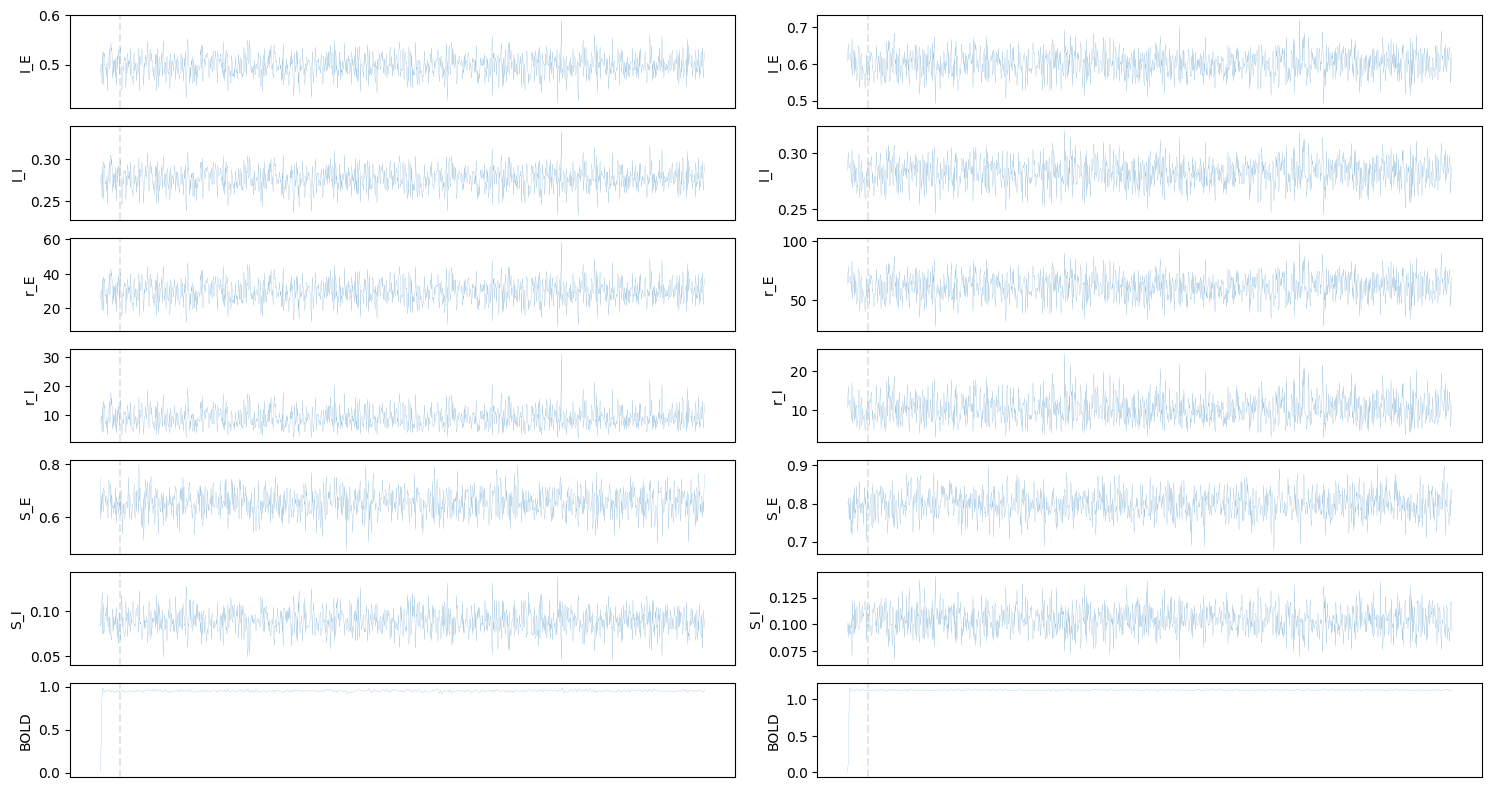

In [5]:
fig, axes = plt.subplots(7, 2, figsize=(15, 8))

for i, feature in enumerate(['I_E', 'I_I', 'r_E', 'r_I', 'S_E', 'S_I', 'BOLD']):
    for j in [0, 1]:
        if feature == 'BOLD':
            ts = sim_group.sim_bold[0, :, j]
        else:
            ts = sim_group.sim_states[feature][0, :, j]
        # plot timeseries
        axes[i, j].plot(ts, linewidth=0.1)
        # add t=15 line (the time before which was removed from FC and FCD calculations)
        if feature == 'BOLD':
            axes[i, j].axvline(sim_group.bold_remove_s // sim_group.TR, linestyle='--', color='grey', alpha=0.2)
        else:
            axes[i, j].axvline(sim_group.bold_remove_s // sim_group.states_sampling, linestyle='--', color='grey', alpha=0.2)
        axes[i, j].set_ylabel(feature)
        if i < len(ts)-1:
            axes[i, j].set_xticks([])
fig.tight_layout(pad=1)

Or visualize time series of all nodes using heat maps (excluding the initial 30 seconds):

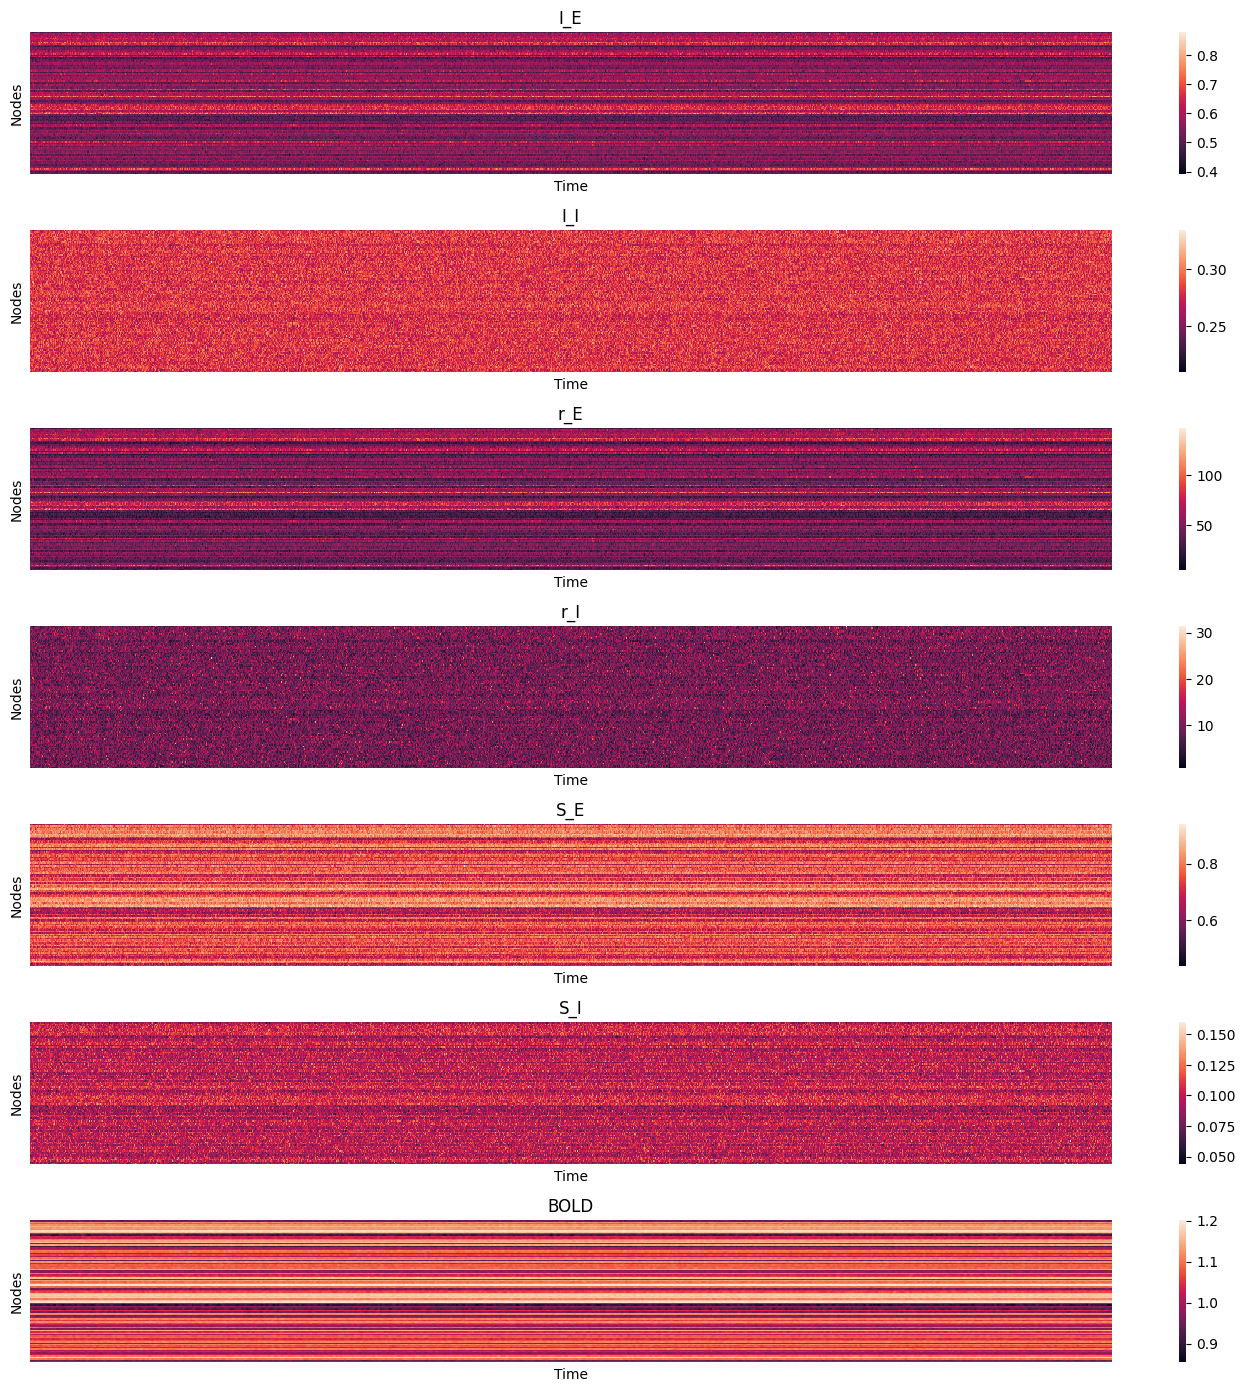

In [6]:
fig, axes = plt.subplots(7, 1, figsize=(14, 14))

for i, feature in enumerate(['I_E', 'I_I', 'r_E', 'r_I', 'S_E', 'S_I', 'BOLD']):
    if feature == 'BOLD':
        ts = sim_group.sim_bold[0, int(sim_group.bold_remove_s // sim_group.TR):].T
    else:
        ts = sim_group.sim_states[feature][0, int(sim_group.bold_remove_s // sim_group.states_sampling):].T
    sns.heatmap(ts, ax=axes[i])
    axes[i].set_ylabel("Nodes")
    axes[i].set_xlabel("Time")
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title(feature)
fig.tight_layout(pad=1)

## Target functional empirical data

As mentioned above, we want our simulation to reflect the functional empirical data of the subject/group we are modeling. Therefore, we should check how well this example simulation reflects the target empirical data by calculating it goodness-of-fit (GOF) to the empirical data. As discussed earlier, the GOF is assessed by comparing measures obtained from the simulated and empirical BOLD signals, reflecting functional network structure of the nodes (using FC) as well as the network dynamics (using FCD). Here, as we aim to create a model representing our group of 706 subjects, we will compare the simulated FC and FCD to the empirical FC and FCD pooled from all the subjects.

### Calculating FC and FCD in a single subject

Before demonstrating the pooled FCs and FCDs across subjects, let's look at the empirical BOLD signal of a single subject and see how its static FC, dynamic FC, and the FCD matrix are calculated. For this, we will load the empirical BOLD time series of the first subject, which is included in the toolbox. This includes BOLD data which is cleaned and parcellated based on Schaefer-100 atlas, which is the same atlas used to define the simulation nodes and their structural connectivity.

<div class="alert alert-info">
<p>
Note: Tools such as [fMRIprep](https://fmriprep.org/en/stable/) + [XCP-D](https://xcp-d.readthedocs.io/en/latest/) or [Micapipe](https://micapipe.readthedocs.io/en/latest/) can be used to preprocess raw rs-fMRI data to such cleaned and parcellated BOLD data which is ready for comparison with the simulated BOLD signal.
</p>
</div>

Text(0.5, 1.0, 'Empirical BOLD')

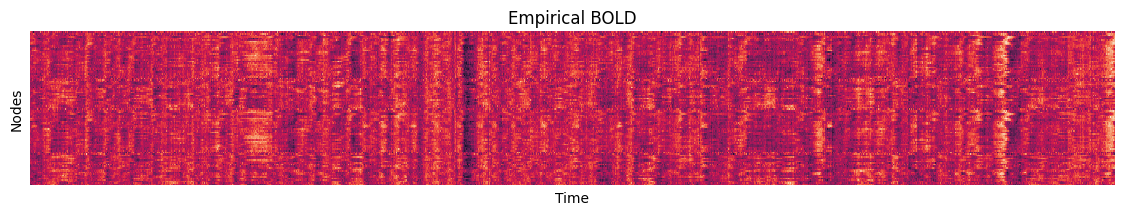

In [7]:
import scipy.stats
emp_bold = datasets.load_bold('schaefer-100', sub='100206', ses='REST1_LR')
# z-score BOLD signal in each node
emp_bold = scipy.stats.zscore(emp_bold, axis=1)

fig, ax = plt.subplots(figsize=(14, 2))
sns.heatmap(emp_bold, cbar=False, ax=ax)
ax.set_ylabel("Nodes")
ax.set_xlabel("Time")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Empirical BOLD")

The functional connectivity between the nodes is simply calculated as the Pearson correlation of their BOLD signals, e.g. between 1st and 10th node:

FC of node 0 and 9 = 0.122


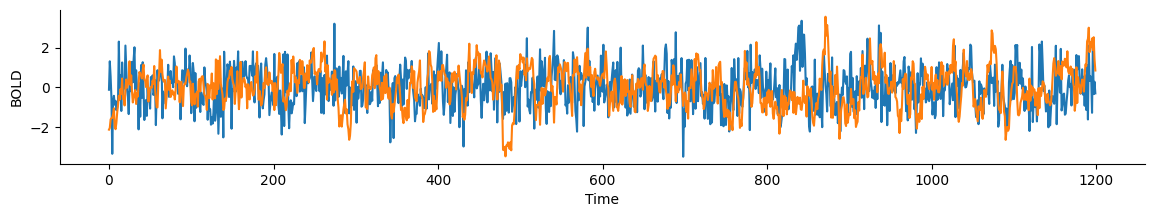

In [8]:
fig, ax = plt.subplots(figsize=(14, 2))
sns.lineplot(emp_bold[0], ax=ax)
sns.lineplot(emp_bold[9], ax=ax)
ax.set_ylabel("BOLD")
ax.set_xlabel("Time")
sns.despine()
print(f"FC of node 0 and 9 = {np.corrcoef(emp_bold[0], emp_bold[9])[0,1]:.3f}")

The FC between all pairs of nodes can be calculated similarly. We will do this using the `cubnm.utils.calculate_fc` function. Note that given interhemispheric connections are ignored in calculation of simulated FC (for reasons described above), we do the same for the empirical FC:

Text(0.5, 1.0, 'Empirical FC (sub-100206)')

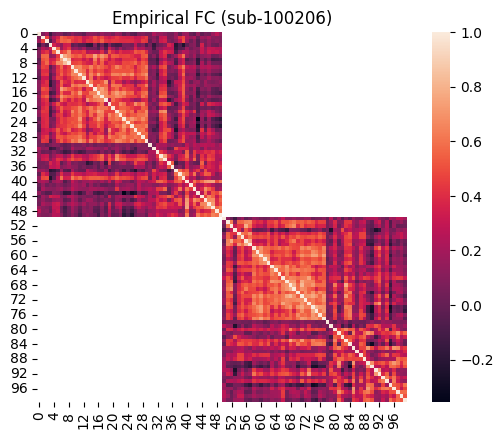

In [9]:
emp_fc_sub = utils.calculate_fc(emp_bold, exc_interhemispheric=True, return_tril=False)

# plot
ax = sns.heatmap(emp_fc_sub, square=True)
ax.set_title("Empirical FC (sub-100206)")

Next, we calculate the FCD matrix. This matrix is created in two steps:
1. Calculate dynamic FC (dFC) across moving windows of time throughout the scan (or simulation), and 
2. Calculate the correlation of FC patterns between different windows. 

We will use `cubnm.utils.calculate_fcd` to calculate both the FCD matrix and dFC. Again, we will ignore inter-hemispheric connections.

In [10]:
emp_fcd_sub, dfc = utils.calculate_fcd(
    emp_bold,
    window_size=sim_group.window_size_TRs, 
    window_step=sim_group.window_step_TRs,
    exc_interhemispheric=True,
    return_dfc=True,
    return_tril=False
)

`dfc` is a `(nodes, nodes, windows)` array containing the FC matrix of each window

In [11]:
dfc.shape

(100, 100, 166)

Given the provided scan, the window size, and window step, we have ended up with 166 moving windows. Let's look at the FC of a few of these windows:

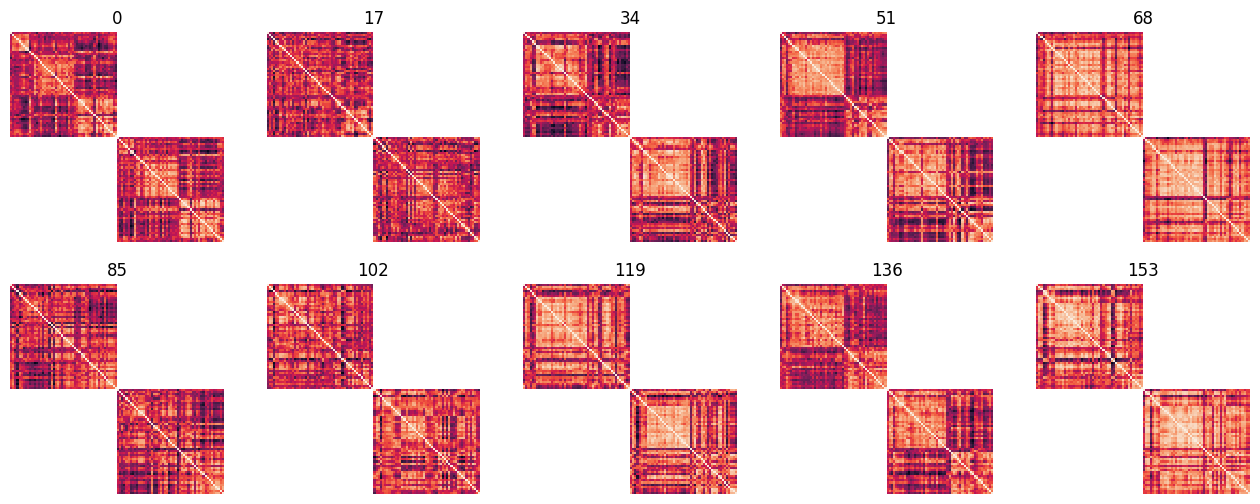

In [12]:
fig, axes = plt.subplots(2, 5, figsize=(16, 6))
axes = axes.flatten()
for i, window in enumerate(range(0, 166, 17)):
    sns.heatmap(dfc[..., window], cbar=False, ax=axes[i])
    axes[i].axis('off')
    axes[i].set_title(window)

We can appreciate that there are some recurring patterns, with some windows that are more similar to each other, but at the same time, several unique patterns of dynamic FC ("states") exist. This can be summarized in the FCD matrix, which shows the correlation between these dynamic FC patterns:

Text(0.5, 1.0, 'Empirical FCD (sub-100206)')

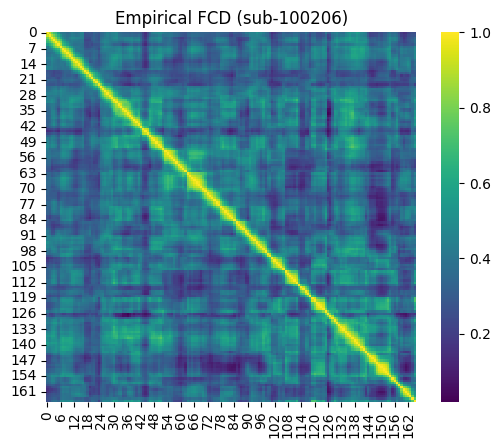

In [13]:
ax = sns.heatmap(emp_fcd_sub, cmap='viridis', square=True)
ax.set_title("Empirical FCD (sub-100206)")

The temporal sequence of dynamic patterns that occur throughout the resting-state/spontaneous BOLD signals across different subjects, and between empirical and simulated data, are not syncronized. Therefore, rather than the specific pattern of the FCD matrix, what is more important to us, is the distribution of values within this matrix. The FCD distribution reflects the level of dynamics-vs-stability of the functional connectivity. If the is no dynamics, and the dFC is constant across windows, their cross-correlation in the FCD will be closer to 1. Conversely, if dFC is chaotic and there is no recurrence of patterns, the dFC patterns will not be correlated to each other, and FCD values will be closer to 0.

We will next plot the distribution of FCD values from this example BOLD signal. Note that since FCD is a symmetric matrix, we'll only look at the values in its lower triangle:

Text(0.5, 1.0, 'Empirical FCD Distribution (sub-100206)')

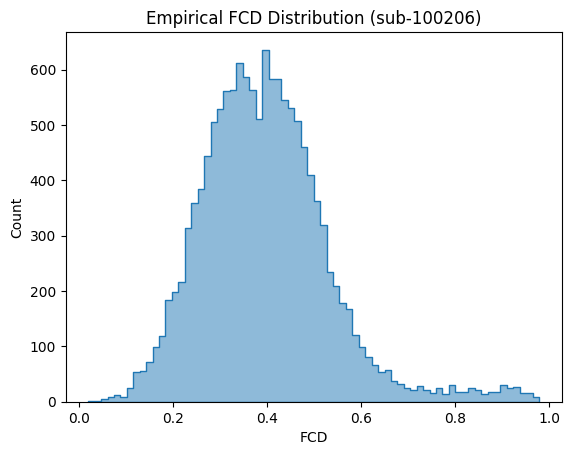

In [14]:
ax = sns.histplot(emp_fcd_sub[np.tril_indices_from(emp_fcd_sub, -1)], element='step', alpha=0.5)
ax.set_xlabel('FCD')
ax.set_title('Empirical FCD Distribution (sub-100206)')

We can see that the FCD values are neither concentrated around 0 (complete chaos) nor 1 (no dynamics), but rather are distributed in between.

### Group-level empirical FC and FCD

Using the same process described above, we can calculate the FC and FCD matrices of all the subjects, and then pool them together. 

To pool the FC across the subjects, we simply take an average across the individual FC matrices. Note that here we do the averaging on Fisher Z transformed correlation coefficients, which are transformed back to correlation coefficients after the average is calculated.

For the FCD, as the temporal structure of scans between subjects are not synchronized, and since we are only interested in the distribution of FCD values, the distribution of FCDs across subjects are pooled (via concatenation and downsampling).

We will not do the group pooling in this tutorial, but rather load the pre-calculated pooled FC and FCD data of the group subjects which is included in the toolbox:

Text(0.5, 1.0, 'Empirical FC (Group)')

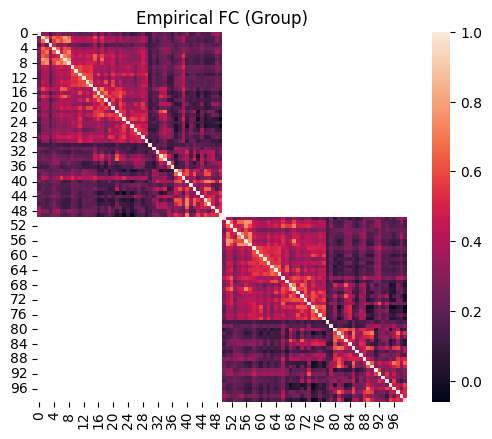

In [15]:
emp_fc = datasets.load_fc('schaefer-100', 'group-train706', exc_interhemispheric=True, return_tril=False)
# plot
ax = sns.heatmap(emp_fc, square=True)
ax.set_title("Empirical FC (Group)")

Text(0.5, 1.0, 'Empirical FCD Distribution (Group)')

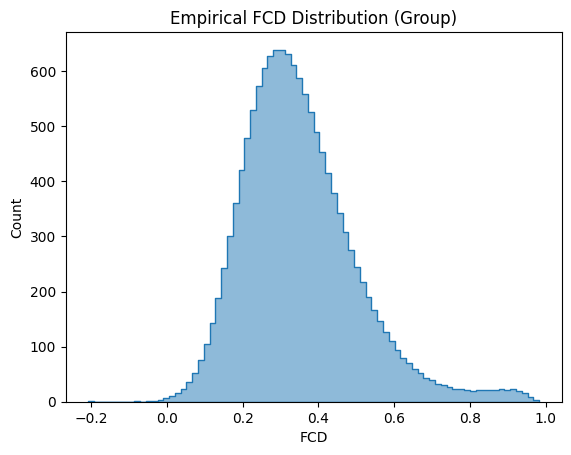

In [16]:
emp_fcd_tril = datasets.load_fcd('schaefer-100', 'group-train706', exc_interhemispheric=True, return_tril=True)
# plot
ax = sns.histplot(emp_fcd_tril, element='step', alpha=0.5)
ax.set_xlabel('FCD')
ax.set_title("Empirical FCD Distribution (Group)")

## Goodness-of-fit to the target functional data

We can obtain the same derivatives, namely, FC matrix and the FCD matrix distribution, from the simulated BOLD data. The simulated FC and FCD matrices are already calculated on the GPU when we called `SimGroup.run()` method. Given both of these matrices are symmetric, only their lower triangles are stored (to use a smaller amount of memory), which are available in `sim_fc_trils` and `sim_fcd_trils` attributes of the `SimGroup` object.

In [17]:
sim_group.sim_fc_trils.shape

(1, 2450)

In [18]:
sim_group.sim_fcd_trils.shape

(1, 13861)

The first axis in these arrays represent the different simulations run in the simulation group, which is a single simulation in this case.

The squared form of the simulated matrices can be obtained using `SimGroup.get_sim_fc()` and `SimGroup.get_sim_fcd()` given a simulation index.

Using this, we obtain the squared form of simulated FC matrix (of the first and only simulation in this `SimGroup` object) and plot it next to the group's empirical FC:

Text(0.5, 1.0, 'Simulated FC')

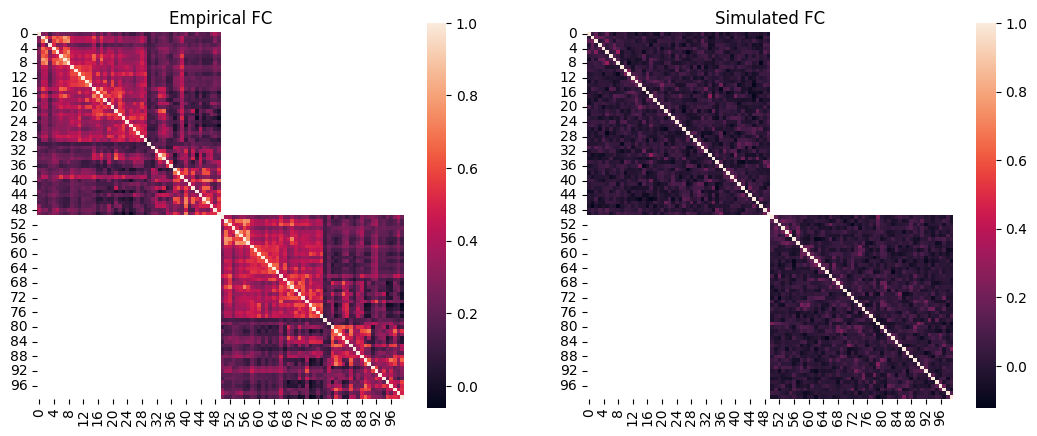

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# plot empirical FC
sns.heatmap(emp_fc, square=True, ax=axes[0])
axes[0].set_title("Empirical FC")

# plot simulated FC
sim_idx = 0
sns.heatmap(sim_group.get_sim_fc(sim_idx), square=True, ax=axes[1])
axes[1].set_title("Simulated FC")

We can quantify the similarity of their patterns using Pearson's correlation. Here we'll use their lower triangles (given they are symmetric) and exclude the interhemispheric connections. For the simulated data this is already available in `sim_group.sim_fc_trils[0]`. But for the empirical data, we'll get this version of the FC by calling `cubnm.datasets.load_fc()` again while setting `return_tril` to `True`.

In [20]:
import scipy

# get the lower triangle of empirical FC excluding interhemispheric connections
emp_fc_tril = datasets.load_fc('schaefer-100', 'group-train706', exc_interhemispheric=True, return_tril=True)

# calculate Pearson correlation
scipy.stats.pearsonr(sim_group.sim_fc_trils[0], emp_fc_tril).statistic

0.21742667523455916

In [21]:
# regression plot
fig, ax = plt.subplots()
sns.regplot(
    x=sim_group.sim_fc_trils[0],
    y=emp_fc_tril,
    scatter_kws=dict(s=5, alpha=0.2, color="grey"),
    line_kws=dict(color="red"),
)
ax.set_xlabel("Simulated FC")
ax.set_ylabel("Empirical FC")

Text(0, 0.5, 'Empirical FC')

Typically we expect this correlation to be better, or at least close to the correlation of SC and empirical FC matrices (aka SC-FC coupling). To calculate this we should again exclude interhemispheric connections and only use the lower triangles.

In [22]:
# calculate SC tril excluding interhemispheric connections
sc_nointer = sc.copy()
sc_nointer[:sim_group.nodes//2, sim_group.nodes//2:] = np.NaN
sc_nointer[sim_group.nodes//2:, :sim_group.nodes//2] = np.NaN
sc_tril = sc_nointer[np.tril_indices_from(sc_nointer, -1)]
sc_tril = sc_tril[~np.isnan(sc_tril)]

# calculate SC-FC coupling across intra-hemispheric connections
scipy.stats.pearsonr(emp_fc_tril, sc_tril).statistic

0.3398926535540525

This indicates that this simulation with arbitrary parameters does not have a very good fit to the target empirical data with respect to the similarity of FC patterns.

How about the dynamics captured in FCD? As mentioned earlier, here we only care about the distribution of values in FCD rather than its specific pattern. Therefore we calculate the difference of the two distributions using the Kolmogorov-Smirnov (KS) distance, with lower values showing more similar distributions.

FCD KS distance = 0.9260990646977411


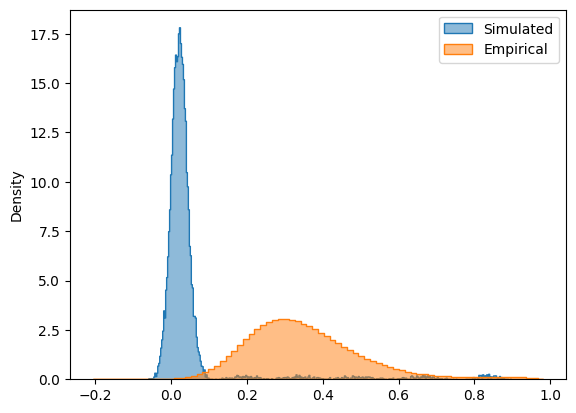

In [23]:
# plot the distributions next to each other
sns.histplot(sim_group.sim_fcd_trils[0], element='step', alpha=0.5, label='Simulated', stat='density')
ax = sns.histplot(emp_fcd_tril, element='step', alpha=0.5, label='Empirical', stat='density')
ax.legend()

# calculate KS distance
print(f"FCD KS distance = {scipy.stats.ks_2samp(emp_fcd_tril, sim_group.sim_fcd_trils[0]).statistic}")

The distributions do not look very similar, as is captured by the KS distance measure, which is close to the maximum possible value of KS distance, equal to 1.

The `SimGroup.score()` method can do all of the GOF calculations, based on the list of requested `gof_terms` (an argument of `SimGroup`). It takes the target empirical data (as `emp_fc_tril` and `emp_fcd_tril` of a given subject or group; or `emp_bold` of a given subject from which FC and FCD will be calculated), does the GOF calculations, and returns them as a table. In this table (a `pandas.DataFrame`) each row is a simulation in the `SimGroup` and the columns include the individual GOF terms as well as their sum, `'+gof'`.

<div class="alert alert-info">
<p>
Note: The calculation of some GOF measures such as FC correlation and FCD KS distance is done on GPUs, if they are available and `cupy` and `numba` are installed (this is done when installing the toolbox with `pip install cubnm[cupy-cuda11x]` or `pip install cubnm[cupy-cuda12x]`)
</p>
</div>


In [24]:
sim_group.score(emp_fc_tril=emp_fc_tril, emp_fcd_tril=emp_fcd_tril)

+fc_corr   -fcd_ks      +gof  -fic_penalty
0  0.217427 -0.926099 -0.708672     -0.436677

<div class="alert alert-info">
<p>
Note: FIC penalty is a metric of how successful FIC was in keeping the mean firing rates across nodes close to 3 Hz. It is not included in `+gof` but will be considered in the optimization algorithms cost function. To disable it pass `fic_penalty_scale=0` to the `cubnm.sim.rWWSimGroup` when setting it up. Note that FIC penalty is specific to rWW model.
</p>
</div>

As we can see, this example simulation does not have a very good fit to the empirical data. Therefore we will have to tune the model parameters. In the next tutorials we will show how to use optimization algorithms to systematically do this. These optimization algorithms involve running many simulations with different parameters, and this is where the benefit or running these simulations on the GPU becomes clear.